In [2]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def estimate_vector_field(
    x0_sampler,
    x1_sampler,
    t,
    grid_size=30,
    n_samples=200_000,
    bandwidth=0.15,
    device="cuda",
    clip=1.0
):
    """
    Empirical conditional expectation E[u_t | x_t = x]
    using Gaussian kernel averaging.
    """

    # Sample large batches
    x0 = x0_sampler(n_samples).to(device)   # (N, 2)
    x1 = x1_sampler(n_samples).to(device)   # (N, 2)

    xt = (1 - t) * x0 + t * x1               # (N, 2)
    ut = x1 - x0                             # (N, 2)

    # Grid
    xmin, xmax = -3.0, 3.0
    ymin, ymax = -3.0, 3.0
    xs = torch.linspace(xmin, xmax, grid_size, device=device)
    ys = torch.linspace(ymin, ymax, grid_size, device=device)
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # (G, 2)

    # Kernel regression
    diffs = grid[:, None, :] - xt[None, :, :]              # (G, N, 2)
    dists2 = (diffs ** 2).sum(dim=-1)                      # (G, N)

    weights = torch.exp(-dists2 / (2 * bandwidth ** 2))    # (G, N)
    weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)

    v = weights @ ut                                       # (G, 2)
    v = v / torch.max(torch.ones_like(v[:,0])*clip, v.norm(dim=1)).unsqueeze(-1)
    return (
        X.cpu().numpy(),
        Y.cpu().numpy(),
        v[:, 0].reshape(grid_size, grid_size).cpu().numpy(),
        v[:, 1].reshape(grid_size, grid_size).cpu().numpy(),
    )


In [102]:
@torch.no_grad()
def estimate_density(
    sampler,
    grid_size=30,
    n_samples=200_000,
    bandwidth=0.15,
    device="cuda"
):
    x = sampler(n_samples).to(device)  # (N, 2)

    xmin, xmax = -3.0, 3.0
    ymin, ymax = -3.0, 3.0
    xs = torch.linspace(xmin, xmax, grid_size, device=device)
    ys = torch.linspace(ymin, ymax, grid_size, device=device)
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # (G, 2)

    diffs = grid[:, None, :] - x[None, :, :]
    dists2 = (diffs ** 2).sum(dim=-1)

    weights = torch.exp(-dists2 / (2 * bandwidth ** 2))
    density = weights.mean(dim=1)

    return (
        X.cpu().numpy(),
        Y.cpu().numpy(),
        density.reshape(grid_size, grid_size).cpu().numpy(),
    )

@torch.no_grad()
def find_nearest_neighbor(set1, set2, identity_threshold=1.e-4):
    distance_matrix = torch.mean((set1[None, ...] - set2[:, None, ...]) ** 2, dim=(-1))
    distance_matrix[distance_matrix < identity_threshold] = torch.inf
    return torch.argmin(distance_matrix, dim=0)

@torch.no_grad()
def estimate_adjustment(X, Y, U, V, fiber_samples, gamma=0.1, clip=1):
    grid_size = len(X)
    grid = torch.stack([torch.from_numpy(X).flatten(), torch.from_numpy(Y).flatten()], dim=1)  # (G, 2)

    nn_ind_fiber_samples = find_nearest_neighbor(grid, fiber_samples, identity_threshold=0.0)
    difference = fiber_samples[nn_ind_fiber_samples] - grid
    
    grid_vf = torch.stack([torch.from_numpy(U).flatten(), torch.from_numpy(V).flatten()], dim=1)  # (G, 2)
    grid_vf_adjusted = grid_vf + difference*gamma
    grid_vf_adjusted = grid_vf_adjusted / torch.max(torch.ones_like(grid_vf_adjusted[:,0])*clip, grid_vf_adjusted.norm(dim=1)).unsqueeze(-1)

    return (
        grid_vf_adjusted[:, 0].reshape(grid_size, grid_size).cpu().numpy(),
        grid_vf_adjusted[:, 1].reshape(grid_size, grid_size).cpu().numpy()
    )

def plot_vector_field(X, Y, U, V, title=None):
    plt.figure(figsize=(6, 6))
    plt.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=10)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    if title is not None:
        plt.title(title)
    plt.axis("equal")
    plt.tight_layout()




def plot_field_with_density(X, Y, U, V, D, title=None):
    plt.figure(figsize=(6, 6))

    # Density
    plt.contourf(X, Y, D, levels=30, cmap="Blues", alpha=0.7)

    # Vector field
    plt.quiver(
        X, Y, U, V,
        color="black",
        angles="xy",
        scale_units="xy",
        scale=6.0,
        width=0.003
    )

    plt.axis("equal")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    if title is not None:
        plt.title(title)
    plt.tight_layout()

def plot_field_with_density_and_adjustment(X, Y, U, V, U_adj, V_adj, D, title=None):
    plt.figure(figsize=(6, 4))

    # Density
    plt.contourf(X, Y, D, levels=30, cmap="Blues", alpha=0.7, label="unconditional density",
)

    # Vector field
    plt.quiver(
        X, Y, U, V,
        color="black",
        angles="xy",
        scale_units="xy",
        scale=5.0,
        width=0.003,
        alpha=0.5,
        label="original denoising steps",

    )

    plt.quiver(
        X, Y, U_adj, V_adj,
        color="#aa0000",
        angles="xy",
        scale_units="xy",
        scale=5.0,
        width=0.003,
        alpha=1.0,
        label="adjusted denoising steps",
    )

    plt.axis("equal")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    if title is not None:
        plt.title(title)
    plt.tight_layout()


/tmp/ipykernel_1900153/3001082530.py:93: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X, Y, D, levels=30, cmap="Blues", alpha=0.7, label="unconditional density",
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


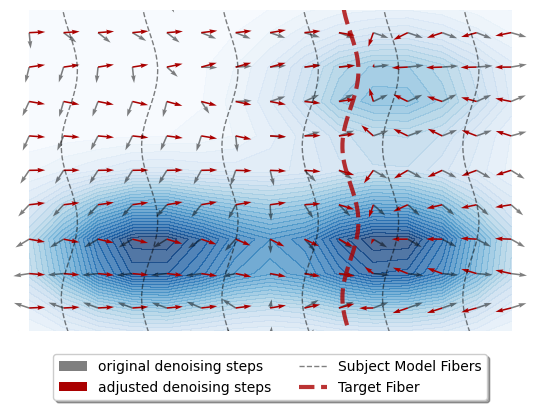

In [124]:
# Example samplers
def x0_sampler(n):
    return torch.randn(n, 2)*2

def x1_sampler(n, mode_3_frac=0.2):
    n_1 = n_2 = int(((1 - mode_3_frac)*n)//2)
    n_3 = n - n_1 - n_2
    mode1 = torch.randn(n_1, 2)*0.5 + torch.tensor([-0.75, -1.0])
    mode2 = torch.randn(n_2, 2)*0.5 + torch.tensor([0.75, -1.0])
    mode3 = torch.randn(n_3, 2)*0.5 + torch.tensor([0.75, 1.0])
    samples =  torch.cat((mode1, mode2, mode3), dim=0)[torch.randperm(n)]
    samples[:,0] *= 2
    return samples

def subject_model_fiber(x, t):
    x_new = x + 0.1*torch.sin(t*20)
    y = t * 6 - 3
    return torch.stack((x_new, y), dim=1)

t = 0.8

# Estimate field
X, Y, U, V = estimate_vector_field(
    x0_sampler,
    x1_sampler,
    t=t,
    n_samples=300_000,
    bandwidth=0.2,
    grid_size=15,

)

# Estimate target density
Xd, Yd, D = estimate_density(
    x1_sampler,
    n_samples=100_000,
    bandwidth=0.2,
    grid_size=15,

)

fiber_samples = subject_model_fiber(1, torch.linspace(0, 1, 100))

U_adj, V_adj = estimate_adjustment(X, Y, U, V, fiber_samples, gamma=5)

plot_field_with_density_and_adjustment(
    X, Y, U, V, U_adj, V_adj, D,
    # title="Empirical FM vector field + target density"
)

for i, anchor in enumerate(torch.linspace(-2.5, 2.5, 6)):
    plt.plot(*subject_model_fiber(anchor, torch.linspace(0, 1, 100)).T, color="#000000", linestyle="dashed", linewidth=1, label="Subject Model Fibers" if i ==0 else None, alpha=0.5)
plt.plot(*fiber_samples.T, color="#aa0000", linestyle="dashed", linewidth=3, label="Target Fiber", alpha=0.8)
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.axis("off")
# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
plt.show()